In [1]:
!pip install mteb
!pip install fsspec==2023.9.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# movies = pd.read_csv('dataset/tmdb_5000_movies.csv')
# credits = pd.read_csv('dataset/tmdb_5000_credits.csv')

In [2]:
movies = pd.read_csv('/content/drive/MyDrive/dataset/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/drive/MyDrive/dataset/tmdb_5000_credits.csv')

# preprocessing

In [3]:
movies.shape


(4803, 20)

In [4]:
credits.shape

(4803, 4)

In [5]:
movies = movies.merge(credits, on='title')

In [6]:
#movies.head(2)

In [7]:
movies.shape

(4809, 23)

In [8]:
# removing unimportant columns since we don't need all of them for the recommender system
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

In [9]:
#movies.head(2)

In [10]:
movies.shape

(4809, 7)

In [11]:
movies.isnull().sum() # checking for null values

,0
movie_id,0
title,0
overview,3
genres,0
keywords,0
cast,0
crew,0


In [12]:
movies.dropna(inplace=True)

In [13]:
movies.shape # shape becomes (4806,7) after removing null values

(4806, 7)

In [14]:
movies.duplicated().sum() # finding duplicated rows

np.int64(0)

In [15]:
#movies.head(2)

Unfortunately, some columns have data in an undesirable format, for example in curly brackets in the column genres

In [16]:
movies.iloc[0]['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

so we can just fetch the genre names, the id of the genres is irrelevant.

In [17]:
import ast # contains function to convert str to list

def convert_genres(txt):
    lst = []
    for i in ast.literal_eval(txt): #literal_eval helps to convert str to list
        lst.append(i['name'])

    return lst

In [18]:
movies['genres'] = movies['genres'].apply(convert_genres)

Now, instead of having genres as a dictionary we simply have a list of genres for each movie in the dataset.

In [19]:
#movies.head(2)

we can do the same for the keywords column. Now, we want to fetch the "name" from the keywords column.

In [20]:
movies['keywords'] = movies['keywords'].apply(convert_genres)
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


Again, doing the same but for the "cast" column. We want to only fetch the main cast (lets say top 3).

In [21]:
def convert_cast(txt):
    lst = []
    c = 0 # establishing a counter
    for i in ast.literal_eval(txt): #literal_eval helps to convert str to list
        if c < 3:
            lst.append(i['name'])
        c += 1

    return lst

In [22]:
movies['cast'] = movies['cast'].apply(convert_cast)
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


Again, let us preprocess the "crew" columns. We want to fetch the director for each movie.

In [23]:
def fetch_director(txt):
    lst = []
    for i in ast.literal_eval(txt): #literal_eval helps to convert str to list
        if i['job'] == 'Director':
            lst.append(i['name'])
            break

    return lst

In [24]:
movies['crew'] = movies['crew'].apply(fetch_director)
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]


Next we need to generate some tags and convert it into embeddings (vectorized form)

In [25]:
movies['overview'] = movies['overview'].apply(lambda x: x.split())
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]


In [26]:
movies.iloc[7]['overview']

['When',
 'Tony',
 'Stark',
 'tries',
 'to',
 'jumpstart',
 'a',
 'dormant',
 'peacekeeping',
 'program,',
 'things',
 'go',
 'awry',
 'and',
 'Earth’s',
 'Mightiest',
 'Heroes',
 'are',
 'put',
 'to',
 'the',
 'ultimate',
 'test',
 'as',
 'the',
 'fate',
 'of',
 'the',
 'planet',
 'hangs',
 'in',
 'the',
 'balance.',
 'As',
 'the',
 'villainous',
 'Ultron',
 'emerges,',
 'it',
 'is',
 'up',
 'to',
 'The',
 'Avengers',
 'to',
 'stop',
 'him',
 'from',
 'enacting',
 'his',
 'terrible',
 'plans,',
 'and',
 'soon',
 'uneasy',
 'alliances',
 'and',
 'unexpected',
 'action',
 'pave',
 'the',
 'way',
 'for',
 'an',
 'epic',
 'and',
 'unique',
 'global',
 'adventure.']

Now we can concated the columns

In [27]:
movies.head(5)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


In [28]:
def remove_spaces(words):
    lst = []
    for i in words:
        lst.append(i.replace(" ", ""))
    return lst


In [29]:
movies['cast'] = movies['cast'].apply(remove_spaces)
movies['crew'] = movies['crew'].apply(remove_spaces)
movies['genres'] = movies['genres'].apply(remove_spaces)
movies['keywords'] = movies['keywords'].apply(remove_spaces)
movies.head(4)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]


Now that we prepared the data from the columns, we can create a new col "tags" which is the concatenation of some of the other columns

In [30]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."


In [31]:
movies.iloc[0]['tags']

['In',
 'the',
 '22nd',
 'century,',
 'a',
 'paraplegic',
 'Marine',
 'is',
 'dispatched',
 'to',
 'the',
 'moon',
 'Pandora',
 'on',
 'a',
 'unique',
 'mission,',
 'but',
 'becomes',
 'torn',
 'between',
 'following',
 'orders',
 'and',
 'protecting',
 'an',
 'alien',
 'civilization.',
 'Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'cultureclash',
 'future',
 'spacewar',
 'spacecolony',
 'society',
 'spacetravel',
 'futuristic',
 'romance',
 'space',
 'alien',
 'tribe',
 'alienplanet',
 'cgi',
 'marine',
 'soldier',
 'battle',
 'loveaffair',
 'antiwar',
 'powerrelations',
 'mindandsoul',
 '3d',
 'SamWorthington',
 'ZoeSaldana',
 'SigourneyWeaver',
 'JamesCameron']

Now using the tags column we can create a new df to work with, since the columns movie_id, title and tags are all we need.

In [32]:
newMoviedf = movies[['movie_id', 'title', 'tags']]
newMoviedf.head(2)

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."


FOr the counter vectoriser we dont need the tags as comma seperated words, instead we need a paragraph.

In [33]:
newMoviedf['tags'] = newMoviedf['tags'].apply(lambda x: " ".join(x))
newMoviedf.head(2)

/tmp/ipython-input-33-2153315532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newMoviedf['tags'] = newMoviedf['tags'].apply(lambda x: " ".join(x))


,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."


In [34]:
newMoviedf.iloc[0]['tags']

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d SamWorthington ZoeSaldana SigourneyWeaver JamesCameron'

In [35]:
newMoviedf['tags'] = newMoviedf['tags'].apply(lambda x: x.lower())
newMoviedf.head(2)

/tmp/ipython-input-35-1116894712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newMoviedf['tags'] = newMoviedf['tags'].apply(lambda x: x.lower())


,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."


In [36]:
newMoviedf.iloc[0]['tags']

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

With the previous steps, we have completed preprocessing. New we can use it to recommend movies.

First we need to do something called "stemming", which is a process that reduces words to their root (e.g., "running" → "run")

In [37]:
import nltk
from nltk.stem import PorterStemmer

In [38]:
ps = PorterStemmer()

In [39]:
def stems(txt):
    lst = []
    for i in txt.split():
        lst.append(ps.stem(i))

    return " ".join(lst)

In [40]:
newMoviedf['tags'] = newMoviedf['tags'].apply(stems)

/tmp/ipython-input-40-2033521672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newMoviedf['tags'] = newMoviedf['tags'].apply(stems)


In [41]:
newMoviedf.iloc[0]['tags']

'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d samworthington zoesaldana sigourneyweav jamescameron'

Now we may perform the countervectorisation

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words='english') #5000 most featured words,
                                                            # stop_words='english' ignores words in the
                                                            # english language such as "in", "as", "a" etc


In [43]:
vector = cv.fit_transform(newMoviedf['tags']).toarray()

In [44]:
vector.shape

(4806, 5000)

Now we can establish similarity between the movies using Cosine similarity.

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [46]:
similarity = cosine_similarity(vector)

In [47]:
similarity

array([[1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
        0.        ],
       [0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
        0.02615329],
       [0.0860309 , 0.06063391, 1.        , ..., 0.02451452, 0.        ,
        0.        ],
       ...,
       [0.04499213, 0.02378257, 0.02451452, ..., 1.        , 0.03962144,
        0.04229549],
       [0.        , 0.        , 0.        , ..., 0.03962144, 1.        ,
        0.08714204],
       [0.        , 0.02615329, 0.        , ..., 0.04229549, 0.08714204,
        1.        ]])

In [48]:
similarity.shape

(4806, 4806)

In [49]:
newMoviedf.iloc[159]['title']

'Spider-Man'

In [50]:
newMoviedf[newMoviedf['title'] == 'Spider-Man'].index[0] # getting index of Spider-Man

np.int64(159)

Finally we can make our recommender function

In [51]:
def recommender(movie_name):
    index = newMoviedf[newMoviedf['title'] == movie_name].index[0]
    dists = sorted(list(enumerate(similarity[index])), reverse=True, key= lambda x: x[1]) # measuring distance of this movie from other movie to find the closest ones
    for i in dists[1:6]:
        print(newMoviedf.iloc[i[0]].title)

In [52]:
recommender('The Avengers')

Iron Man 3
Avengers: Age of Ultron
Captain America: Civil War
Captain America: The First Avenger
Iron Man


In [53]:
# import pickle
# pickle.dump(newMoviedf, open('artifacts/movie_list.pkl','wb'))
# pickle.dump(similarity, open('artifacts/similarity.pkl','wb'))

Combining Text Features for Embedding

In [54]:
def collapse_features(row):
    return " ".join(row['overview']) + " " + " ".join(row['genres']) + " " + " ".join(row['keywords']) + " " + " ".join(row['cast']) + " " + " ".join(row['crew'])

movies['tags'] = movies.apply(collapse_features, axis=1)


# Generating Embeddings

Computing Cosine Similarity Matrix:
Now to replace the CountVectorizer-based similarity calculation with:


## Load and Encode with Multiple Embedding Models

In [55]:
# Define embedding models to compare
models = {
    'Sentence-BERT (MiniLM)': SentenceTransformer('all-MiniLM-L6-v2'),
    'E5-base': SentenceTransformer('intfloat/e5-base'),
    'e5-large-v2': SentenceTransformer('intfloat/e5-large-v2'),
    'mxbai-embed-large-v1': SentenceTransformer('mixedbread-ai/mxbai-embed-large-v1')

}

# Store embeddings for each model
model_embeddings = {}
for name, model in models.items():
    print(f"Generating embeddings using {name}...")
    model_embeddings[name] = model.encode(movies['tags'].values, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/356 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Generating embeddings using Sentence-BERT (MiniLM)...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Generating embeddings using E5-base...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Generating embeddings using e5-large-v2...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Generating embeddings using mxbai-embed-large-v1...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

### Computing cosine similarity for each model

In [56]:
# Compute similarity matrices
model_similarities = {}
for name, embeddings in model_embeddings.items():
    print(f"Computing cosine similarity for {name}...")
    model_similarities[name] = cosine_similarity(embeddings)

Computing cosine similarity for Sentence-BERT (MiniLM)...
Computing cosine similarity for E5-base...
Computing cosine similarity for e5-large-v2...
Computing cosine similarity for mxbai-embed-large-v1...


# Recommend

In [57]:
def RecMovie(movie_title, model_name):
    movie = movie_title.lower()
    if movie not in movies['title'].str.lower().values:
        print(f"'{movie}' not found in movie titles.")
        return

    # Use pre-computed model_similarities
    if model_name not in model_similarities:
        print(f"Model '{model_name}' not found. Available models are: {list(model_similarities.keys())}")
        return

    idx = movies[movies['title'].str.lower() == movie].index[0]
    sim_matrix = model_similarities[model_name]
    distances = list(enumerate(sim_matrix[idx]))
    sorted_movies = sorted(distances, key=lambda x: x[1], reverse=True)[1:6]

    print(f"Top 5 recommendations using {model_name} for '{movie_title}':")
    for i in sorted_movies:
        print(f"- {movies.iloc[i[0]].title}")

# Example usage with the pre-computed models
RecMovie('The Avengers', 'Sentence-BERT (MiniLM)')
RecMovie('The Avengers', 'E5-base')
RecMovie('The Avengers', 'e5-large-v2')
RecMovie('The Avengers', 'mxbai-embed-large-v1')

Top 5 recommendations using Sentence-BERT (MiniLM) for 'The Avengers':
- Avengers: Age of Ultron
- Captain America: The Winter Soldier
- Ant-Man
- Iron Man
- Captain America: Civil War
Top 5 recommendations using E5-base for 'The Avengers':
- Avengers: Age of Ultron
- Iron Man
- The Incredible Hulk
- X-Men: Apocalypse
- Ant-Man
Top 5 recommendations using e5-large-v2 for 'The Avengers':
- Avengers: Age of Ultron
- Captain America: The Winter Soldier
- Iron Man 3
- Iron Man
- Iron Man 2
Top 5 recommendations using mxbai-embed-large-v1 for 'The Avengers':
- Avengers: Age of Ultron
- Captain America: The Winter Soldier
- The Incredible Hulk
- X2
- Fantastic Four


# Evaluation using MTEB

In [58]:
from mteb import MTEB
# Load the model for evaluation
model = SentenceTransformer("all-MiniLM-L6-v2")  # or "intfloat/e5-base"

# Define the benchmark tasks (small example)
evaluation = MTEB(tasks=["STSBenchmark", "SciFact"], task_langs=["en"]) # set tasks = SciFact, STSBenchmark,MSMARCO one by one

# Run evaluation
evaluation.run(model, output_folder="results_MiniLM")

/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:109: UserWarning: The `task_langs` argument is deprecated and will be removed in the 2.0 release. Please use `tasks = mteb.get_tasks(... languages = [...])` to filter tasks instead. Note that this uses 3 letter language codes (ISO 639-3).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

STS

- STSBenchmark, s2s

README.md:   0%|          | 0.00/8.25k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/8.02M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/129k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

[TaskResult(task_name=SciFact, scores=...),
 TaskResult(task_name=STSBenchmark, scores=...)]

The intfloat/e5-base model is trained with special tokens like "query: ..." and "passage: ...". Also, it expects normalized embeddings (L2-normalized vectors).

To use it correctly in MTEB, you must wrap the model to preprocess input properly.



In [59]:
from sentence_transformers import SentenceTransformer, models
import torch

# Load E5 model
model = SentenceTransformer("intfloat/e5-base")

# Redefine the encode method to add the prefix and normalize embeddings
original_encode = model.encode
model.encode = lambda sentences, **kwargs: torch.nn.functional.normalize(
    original_encode(["query: " + s for s in sentences], **kwargs), p=2, dim=1
)

# Evaluate on one task
evaluation = MTEB(tasks=["STSBenchmark","SciFact"], task_langs=["en"])
evaluation.run(model, output_folder="results_E5")

/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:109: UserWarning: The `task_langs` argument is deprecated and will be removed in the 2.0 release. Please use `tasks = mteb.get_tasks(... languages = [...])` to filter tasks instead. Note that this uses 3 letter language codes (ISO 639-3).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

STS

- STSBenchmark, s2s

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

[TaskResult(task_name=SciFact, scores=...),
 TaskResult(task_name=STSBenchmark, scores=...)]

In [60]:

# Define models and output folders
model_configs = {
    "e5-large-v2": {
        "name": "intfloat/e5-large-v2",
        "output": "results_e5_large_v2"
    },
    "mxbai-embed-large-v1": {
        "name": "mixedbread-ai/mxbai-embed-large-v1",
        "output": "results_mxbai"
    }
}

# Tasks to evaluate on
tasks = ["STSBenchmark", "SciFact"]

# Loop through and evaluate each model
for label, config in model_configs.items():
    print(f"\nRunning MTEB for: {label}")
    model = SentenceTransformer(config["name"])
    for task in tasks:
        print(f"  Task: {task}")
        evaluation = MTEB(tasks=[task], task_langs=["en"])
        evaluation.run(model, output_folder=f"{config['output']}/{task}")



Running MTEB for: e5-large-v2
  Task: STSBenchmark


/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:109: UserWarning: The `task_langs` argument is deprecated and will be removed in the 2.0 release. Please use `tasks = mteb.get_tasks(... languages = [...])` to filter tasks instead. Note that this uses 3 letter language codes (ISO 639-3).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

  Task: SciFact


/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:109: UserWarning: The `task_langs` argument is deprecated and will be removed in the 2.0 release. Please use `tasks = mteb.get_tasks(... languages = [...])` to filter tasks instead. Note that this uses 3 letter language codes (ISO 639-3).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]


Running MTEB for: mxbai-embed-large-v1
  Task: STSBenchmark


/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:109: UserWarning: The `task_langs` argument is deprecated and will be removed in the 2.0 release. Please use `tasks = mteb.get_tasks(... languages = [...])` to filter tasks instead. Note that this uses 3 letter language codes (ISO 639-3).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

  Task: SciFact


/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:109: UserWarning: The `task_langs` argument is deprecated and will be removed in the 2.0 release. Please use `tasks = mteb.get_tasks(... languages = [...])` to filter tasks instead. Note that this uses 3 letter language codes (ISO 639-3).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mteb/evaluation/MTEB.py:120: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- SciFact, s2p

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [ ]:
#!pip install transformers torch

## Calculating the improvments

In [61]:
import json
import pandas as pd
from IPython.display import display

# Load all result files
files = {
    "E5_STSBenchmark": "/content/results_E5/intfloat__e5-base/b533fe4636f4a2507c08ddab40644d20b0006d6a/STSBenchmark.json",
    "MiniLM_STSBenchmark": "/content/results_MiniLM/sentence-transformers__all-MiniLM-L6-v2/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/STSBenchmark.json",
    "E5_SciFact": "/content/results_E5/intfloat__e5-base/b533fe4636f4a2507c08ddab40644d20b0006d6a/SciFact.json",
    "MiniLM_SciFact": "/content/results_MiniLM/sentence-transformers__all-MiniLM-L6-v2/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/SciFact.json",
    "E5- Large_STSBenchmark": "/content/results_e5_large_v2/STSBenchmark/intfloat__e5-large-v2/f169b11e22de13617baa190a028a32f3493550b6/STSBenchmark.json",
    "mxbai_STSBenchmark": "/content/results_mxbai/STSBenchmark/mixedbread-ai__mxbai-embed-large-v1/db9d1fe0f31addb4978201b2bf3e577f3f8900d2/STSBenchmark.json",
    "E5- Large_SciFact": "/content/results_e5_large_v2/SciFact/intfloat__e5-large-v2/f169b11e22de13617baa190a028a32f3493550b6/SciFact.json",
    "mxbai_SciFact": "/content/results_mxbai/SciFact/mixedbread-ai__mxbai-embed-large-v1/db9d1fe0f31addb4978201b2bf3e577f3f8900d2/SciFact.json",

}

results = {}
for name, file in files.items():
    with open(file, 'r') as f:
        data = json.load(f)
        model = name.split('_')[0]
        task = data['task_name']
        main_score = data['scores']['test'][0]['main_score']

        if model not in results:
            results[model] = {}
        results[model][task] = main_score

# Create comparison table
comparison = []
for model, tasks in results.items():
    comparison.append({
        'Model': model,
        'STSBenchmark (Spearman)': tasks.get('STSBenchmark', 'N/A'),
        'SciFact (nDCG@10)': tasks.get('SciFact', 'N/A')
    })

df = pd.DataFrame(comparison)

# Calculate relative improvements
mini_sts = df[df['Model'] == 'MiniLM']['STSBenchmark (Spearman)'].values[0]
mini_sci = df[df['Model'] == 'MiniLM']['SciFact (nDCG@10)'].values[0]

df['Relative Improvement (STS)'] = df.apply(
    lambda x: f"+{(x['STSBenchmark (Spearman)'] - mini_sts)/mini_sts*100:.2f}%"
    if x['Model'] != 'MiniLM' else 'Baseline', axis=1)

df['Relative Improvement (SciFact)'] = df.apply(
    lambda x: f"+{(x['SciFact (nDCG@10)'] - mini_sci)/mini_sci*100:.2f}%"
    if x['Model'] != 'MiniLM' else 'Baseline', axis=1)

# Format numeric columns
df['STSBenchmark (Spearman)'] = df['STSBenchmark (Spearman)'].apply(lambda x: f"{x:.4f}")
df['SciFact (nDCG@10)'] = df['SciFact (nDCG@10)'].apply(lambda x: f"{x:.4f}")

# Display final comparison table
display(df[['Model', 'STSBenchmark (Spearman)', 'Relative Improvement (STS)',
            'SciFact (nDCG@10)', 'Relative Improvement (SciFact)']])

,Model,STSBenchmark (Spearman),Relative Improvement (STS),SciFact (nDCG@10),Relative Improvement (SciFact)
0,E5,0.8618,+5.06%,0.6863,+6.39%
1,MiniLM,0.8203,Baseline,0.6451,Baseline
2,E5- Large,0.8455,+3.07%,0.7177,+11.25%
3,mxbai,0.8929,+8.85%,0.7389,+14.55%


## Bar chart of benchmark score

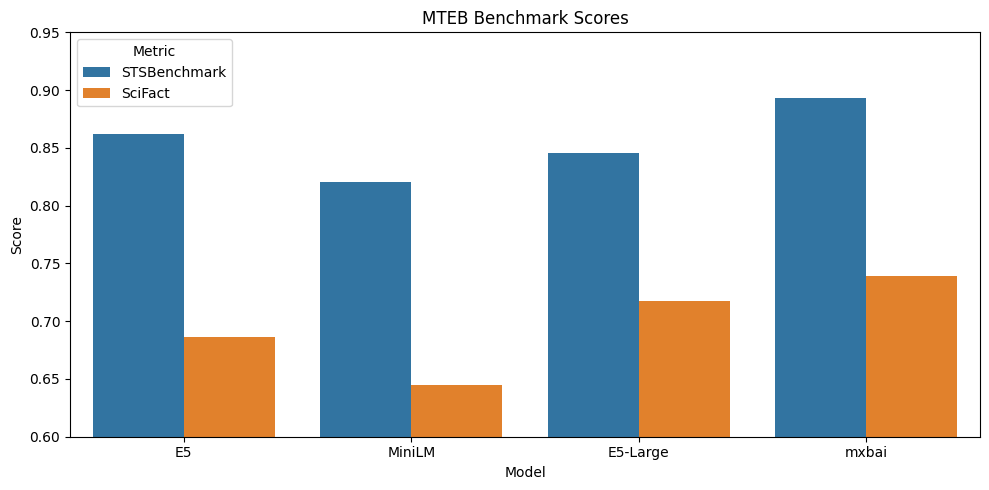

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the MTEB benchmark results
data = {
    "Model": ["E5", "MiniLM", "E5-Large", "mxbai"],
    "STSBenchmark": [0.8618, 0.8203, 0.8455, 0.8929],
    "SciFact": [0.6863, 0.6451, 0.7177, 0.7389],
}
df = pd.DataFrame(data)

# Barplot for scores
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted)
plt.title("MTEB Benchmark Scores")
plt.ylim(0.6, 0.95)
plt.tight_layout()
plt.show()
